In [1]:
options(tidyverse.quiet=TRUE)
suppressWarnings(library(httr))
suppressWarnings(library(jsonlite))
suppressWarnings(library(tidyverse))

set.seed(1)
theme_set(theme_minimal())

In [2]:
# json query is generated from this website: https://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__HE__HE0110__HE0110A/SamForvInk2/table/tableViewLayout1/
json_post = '{
  "query": [
    {
      "code": "Region",
      "selection": {
        "filter": "vs:RegionRiket99",
        "values": []
      }
    },
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1+2"
        ]
      }
    },
    {
      "code": "Alder",
      "selection": {
        "filter": "item",
        "values": [
          "tot16+"
        ]
      }
    },
    {
      "code": "Inkomstklass",
      "selection": {
        "filter": "item",
        "values": [
          "0",
          "1-19",
          "20-39",
          "40-59",
          "60-79",
          "80-99",
          "100-119",
          "120-139",
          "140-159",
          "160-179",
          "180-199",
          "200-219",
          "220-239",
          "240-259",
          "260-279",
          "280-299",
          "300-319",
          "320-339",
          "340-359",
          "360-379",
          "380-399",
          "400-499",
          "500-599",
          "600-799",
          "800-999",
          "1000+"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "HE0110K4",
          "HE0110K3"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2018"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}'

# Querying the data

Ok, now that we have our json query, let's call the API using the httr package and format our data:

In [3]:
income_data = POST(
    "http://api.scb.se/OV0104/v1/doris/sv/ssd/START/HE/HE0110/HE0110A/SamForvInk2", 
    content_type_json(), 
    body=json_post, 
    encode='json')

df = fromJSON(content(income_data, 'text'))$data %>% 
  as_tibble() %>% 
  unnest(values) %>% 
  mutate(income_bucket_tkr = map_chr(key, function(x) x[[3]])) %>%
  select(-key)
                                            
df = df %>% 
  mutate(columns=rep(c('sum', 'n_people'), nrow(df)/2)) %>% 
  pivot_wider(names_from=columns, values_from=values) %>%
  mutate(sum=as.numeric(sum),
        n_people=as.numeric(n_people),
        sum_tkr=sum*1000,
        avg_tkr=(sum/n_people)*1000) %>%
  select(-sum)
                                            
df

income_bucket_tkr,n_people,sum_tkr,avg_tkr
<chr>,<dbl>,<dbl>,<dbl>
0,497842,0,0.000000
1-19,291786,2472400,8.473333
20-39,164081,4870800,29.685338
40-59,153923,7702500,50.041254
60-79,127220,8875100,69.761830
80-99,181623,16580200,91.289099
100-119,282285,31267400,110.765361
120-139,263903,34370100,130.237625
140-159,299528,44976200,150.156914


# An approximation of individual-level data from the aggregate data

The aggregate data has buckets so that we know how many individuals fall into each bucket.  Some of the buckets are narrow -- up until the 400k SEK mark, all buckets cover a range of only 20k SEK.  After the 400K mark however, the income range of the buckets increases to 100k SEK until the 1M SEK mark.  From there all values above 1M SEK are lumped into a single bucket.  The data doesn't give the upper range of the distribution, but this was easy to find on Google (remember, income data is public in Sweden).  I'll use this highest value to get the upper range of the distribution.  

Now, to make an individual-level approximation I'll to pull a random draw from each bucket, the number of observations per draw corresponding to the total number of individuals in that bucket.  For the buckets below 1M I'll use a uniform distribution with the range of the bucket as the lower and upper limit.  For the narrow-range buckets this is probably quite a good approximation, but as the buckets widen this approximation gets worse.  This is the same logic as Riemann sums in calculus, the smaller the range of the buckets, the better the approximation to a continuous distribution.  

For the 1M SEK and up bucket a uniform distirbution will be poor.  So instead, I'll use an exponential distribution which will provide a distribution for which the bulk of observations are at the lower end of the range with a long tail that represents the few extreme outliers.  

In [4]:
# highest salary is from here: https://www.nyteknik.se/ingenjorskarriar/lonelista-spotify-chefen-i-inkomsttoppen-6983087
highest_salary_2018 = 332000

# we'll create an aggregate dataset that includes the lower and upper limit of each bucket
df2 = df %>%
  mutate(bucket_min = map_chr(income_bucket_tkr, function(x) strsplit(x, '-')[[1]][1]),
        bucket_max = map_chr(income_bucket_tkr, function(x) strsplit(x, '-')[[1]][2])) %>%
  mutate(bucket_max = ifelse(is.na(bucket_max) & bucket_min=='0', '0',
                              ifelse(is.na(bucket_max) & bucket_min=='1000+', 
                                     as.character(highest_salary_2018), 
                                     bucket_max)) %>% as.numeric()
        ) %>%
  mutate(bucket_min = ifelse(bucket_min=='1000+', 
                             '1000', 
                             bucket_min) %>% as.numeric()
        )


# create an empty df to fill with individual-level observations
inc = tibble(
    bucket = NA,
    value = NA
)

# this loops over the aggregated df and pulls random draws from a uniform or exponential 
# distribution depending on bucket 
for(i in 1:nrow(df2)){
    if(i != nrow(df2)){
        inc = bind_rows(
            inc, 
            tibble(
                bucket = rep(df2[[i, 1]], df2[[i, 2]]),
                value = runif(df2[[i, 2]],
                        df2[[i, 5]],
                        df2[[i, 6]])
            )
        )
    } else {
        inc = bind_rows(
            inc, 
            tibble(
                bucket = rep(df2[[i, 1]], df2[[i, 2]]),
                value = rexp(df2[[i, 2]], rate=0.04) + 1)
        )
        
    }
}

# format the bucket values for the 1M + SEK obsefvations and drop the nas used when I instantiated the df
inc = inc %>%
  mutate(value = ifelse(bucket=='1000+', 
                        value*1000, 
                        value)
        ) %>%
  drop_na()

Here's the resulting dataset:

In [5]:
print(head(inc))
print(tail(inc))

# A tibble: 6 x 2
  bucket value
  <chr>  <dbl>
1 0          0
2 0          0
3 0          0
4 0          0
5 0          0
6 0          0
# A tibble: 6 x 2
  bucket  value
  <chr>   <dbl>
1 1000+   3515.
2 1000+  21317.
3 1000+  28802.
4 1000+  34571.
5 1000+  22247.
6 1000+  57406.


Some sanity checks, we can confirm that the max value is somewhere close to the true highest income:

In [6]:
max(inc$value)

[1] 294063.2

And we can confirm that the number of 'individuals', in the new dataset equals the sum of the number of individuals per bucket in the aggregate data:

In [7]:
nrow(inc) == sum(df2$n_people)

[1] TRUE

## Ok, let's plot

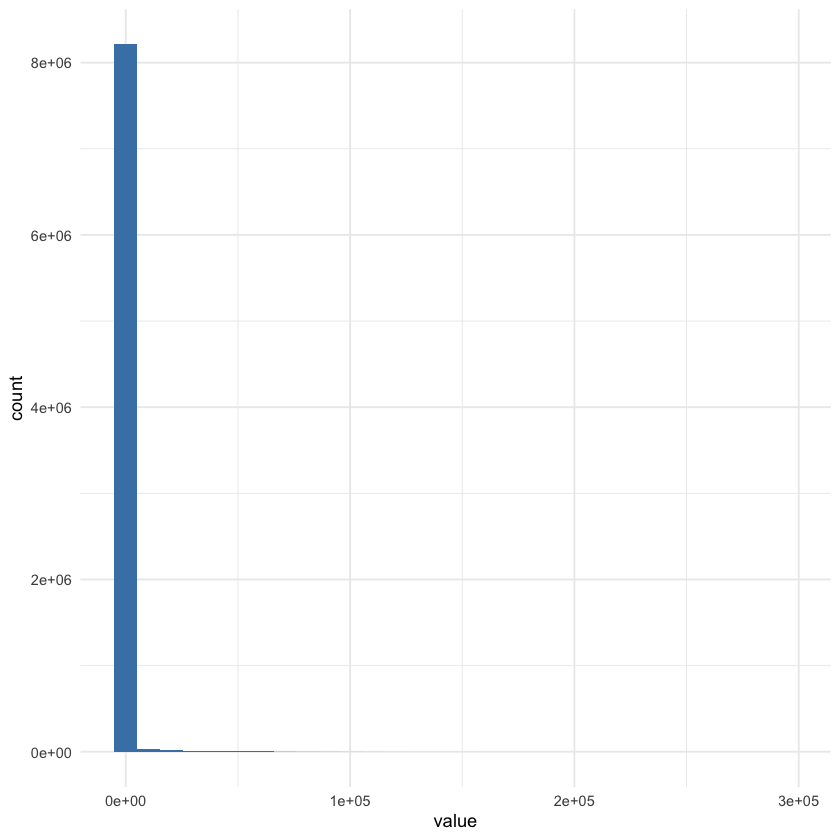

In [8]:
inc %>%
  ggplot(aes(x=value)) + 
  geom_histogram(bins=30, fill='steelblue')

A loooooonnngg tail....

The tail is so long that basically all observations get thrown into a single bin, making the histogram entirely useless.  We can split the data into those below the 1 million SEK mark, and those above to get a better view:

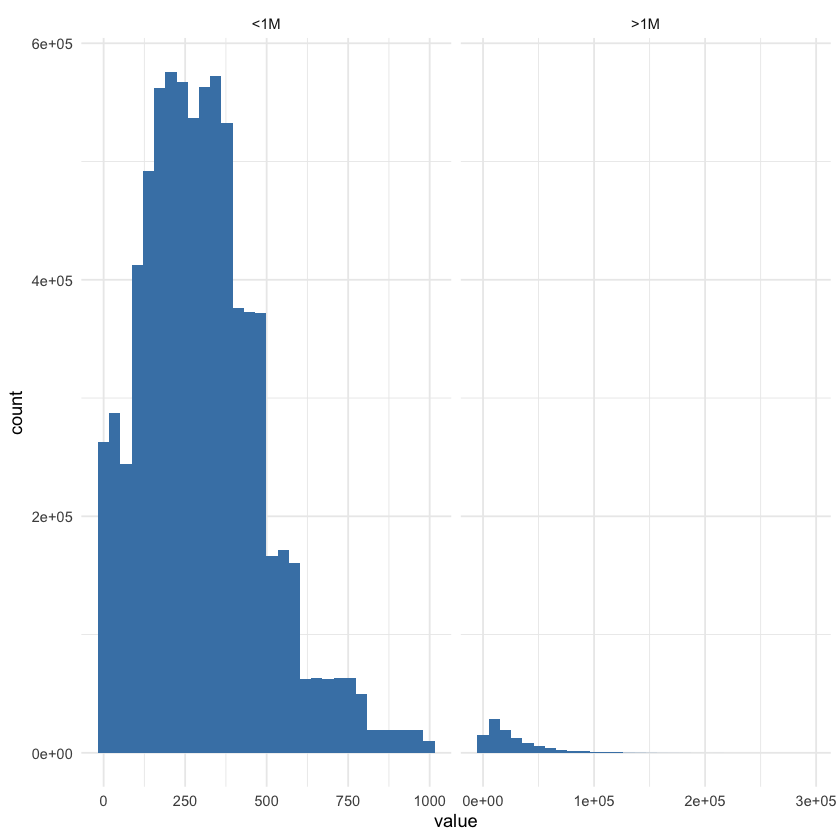

In [9]:
inc %>%
  filter(value>0) %>%
  mutate(`1M+ bucket` = ifelse(value >= 1000, '>1M', '<1M')) %>%
  ggplot(aes(x=value)) + 
  geom_histogram(bins=30, fill='steelblue') + 
  facet_wrap(~`1M+ bucket`, scales='free_x')

This distribution isn't perfect, it looks like it has step functions, but it's good enough to demonstrate the point of the post -- AB testing with extreme outliers.  Just out of curiosity, and as a sanity check, let's what 1M SEK per year places you on the income scale.

In [10]:
inc %>% select(value) %>%
  arrange(by=value) %>%
  mutate(row_n = row_number()) %>%
  filter(value >= 1000) %>%
  filter(row_n == min(.$row_n)) %>%
  pull(row_n) / nrow(inc)

[1] 0.9878676

1M SEK in income almost puts you into the top 1% in Sweden.  That's roughly \\$110,000 USD.  

We could of course have gotten the same answer with the aggregate data...

In [11]:
ppl_over_1M = df2 %>% 
  filter(income_bucket_tkr=='1000+') %>% 
  pull(n_people)

ppl_under_1M = sum(df2$n_people) - ppl_over_1M

# the percentile:
ppl_under_1M / sum(df2$n_people)

[1] 0.9878675

## To the point, what happens to the sampling distribution when there are extreme outliers?

Let's start by filtering out those with 0 income.  Then we can repeatedly pull random samples from this distribution to create approximated sampling distributions.  

In [12]:
inc_working = inc %>%
  filter(value > 0)

In [13]:
sample_means = function(df, var, sample_size){
    v = enquo(var)
    df %>% 
      select(!!v) %>% 
      sample_n(sample_size) %>% 
      summarise(mean_ = mean(!!v)) %>% 
      pull(mean_)
}

In [14]:
sampling_dist_100 = replicate(10000, 
                              sample_means(inc_working, value, 100)
                             )

sampling_dist_1000 = replicate(10000, 
                               sample_means(inc_working, value, 1000)
                              )

sampling_dist_10000 = replicate(10000, 
                                sample_means(inc_working, value, 10000)
                               )

Now we have three approximate sampling distributions, each with 10,000 observations.  The first sampling distribution consists of random samples of 100 individuals; the second sampling distribution consists of random samples of 1,000 individuals; and the third random samples of 10,000 individuals.  

We can see how this difference in sample size impacts the shape of the sampling distribution in the plot below.  The plot to the left, which is constructed from samples of 100 individuals, is highly right-skewed. Remember, the general rule of thumb for more well-behaved distributions is that the CLT applies when n>30.  But even with 100 individuals in our samples, the sampling distribution isn't even close to a normal approximation.  


In the middle plot the sample size was increased to 1,000 individuals, but still here we get right-skew in our sampling distribution.  Not until we hit 10,000 individuals per sample does the sampling distribution approximate normal.


In other words, the CLT still applies even when we have extreme outliers, but we need a much larger sample to get there.  

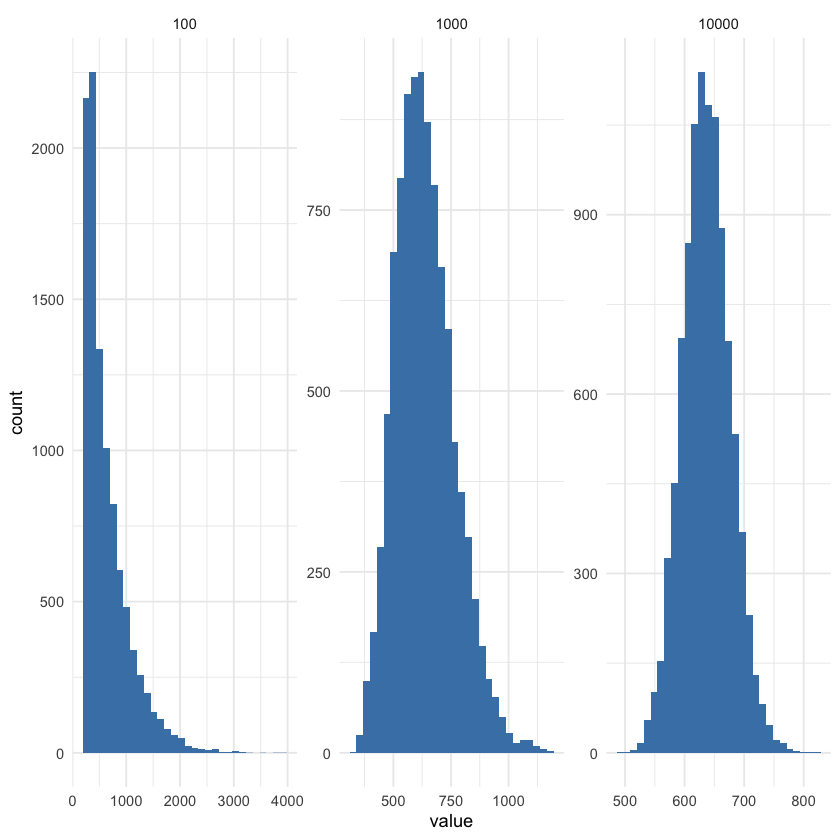

In [15]:
tibble(
    sample_size = c(rep(100, 10000), rep(1000, 10000), rep(10000, 10000)),
    value = c(sampling_dist_100, sampling_dist_1000, sampling_dist_10000)
) %>%
  ggplot(aes(x=value)) + 
  geom_histogram(bins=30, fill='steelblue') + 
  facet_wrap(~sample_size, scales='free')

## Why you shouldn't use distributions with extreme outliers as AB test metrics

Now that we've seen that the CLT still applies even if there are extreme outliers, I still claim that you shouldn't use this type of metric in an AB test.  There are two reasons for this.  First, you will need larger sample sizes than with more well-behaved distributions... And you will have to take this into consideration when conducting a power analysis.  But there is no hard and fast rule here, the size of sample you would require depends entirely on the number and extremeness of the outliers.  All this makes creating an accurate power analysis very difficult, and you'd likely have to rely on strong assumptions and simulations.  

Second, and probably more important, the mean of this distribution doesn't likley give you the information you are interested in.  Generally the mean is userful because it provides a measure of centrality of the given distribution.  We are interested in centrality because we want to know what kind of value we would expect, give or take, if we were to pull a random user from the population.  But extreme outliers have a large influence on the mean, which makes it, in most cases, a poor representation of the distribution.  

We can show this by plotting the mean value of the income data along with the histogram of the distribution.  We'll zoom in on the part of the distribution that contains income values below 1M SEK, which as we saw earlier, contains just over 98% of the values in the data.  

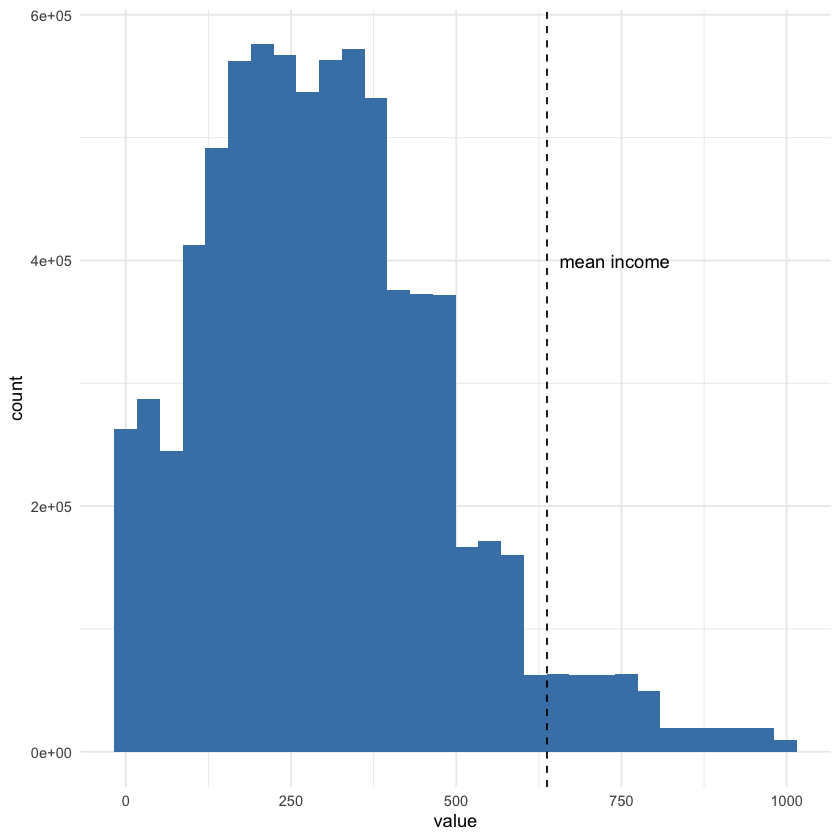

In [16]:
under_1m = inc_working %>%
  filter(value > 0 & value < 1000)

under_1m %>%
  ggplot(aes(x=value)) + 
  geom_histogram(bins=30, fill='steelblue') + 
  geom_vline(xintercept=mean(inc_working$value), linetype='dashed') + 
  annotate('text', label='mean income', y=4e5, x=740)

We can see here that the mean value for the distribution is very far from the bulk of the observations.  If we were to pull a random observation from this dataset, it is very unlikely that the value would be close to the mean -- a random observation would be below the mean in the vast majority of cases.  We can look at the percentile of the mean to estimate the likelihood that a random draw would produce a value below the mean of the distribution

In [17]:
dist_mean = mean(inc_working$value)

inc_working %>% 
  select(value) %>%
  arrange(value) %>%
  mutate(row_n = row_number()) %>% 
  filter(value >= dist_mean) %>%
  filter(row_n == min(.$row_n)) %>%
  pull(row_n) / nrow(inc_working)

[1] 0.9350861

The mean value of this (approximated) Swedish population income data from 2018 corresponds to, roughly, the 93rd percentile!  In other words, if you were to draw a random observation from this data, ~93% of the time it will produce a value below the population mean.  


This is a well-known problem with income data, and skewed distributions in general -- the mean is a poor measure of centrality of the distribution.  But, this also means that the sampling distribution of the mean is equally poor. 




# So, what do you do?

If you have a metric that you want to test but you know that there are extreme outliers, what do you do?  You know that you shouldn't design an AB test using this metric, but then how should you design the AB test?  There's no single right answer, but there are a couple of options, each with their own positives and negatives:

* **Transform the metric, eg with a log.**
    * Positive: this helps with the sample size problem.
    * Negative: It does not help with the second problem, the mean will still be largely unrepresentative for the distribution.
* **Dichotomize the metric, eg the proportion of observations above X.**
    * Positive: gives a useful metric for testing
    * Negative: is this the metric you are interested in?
* **Choose a different metric for your test.**
    * Positive: gives a useful metric for testing
    * Negative: is this the metric you are interested in?
* **Study the percentiles, eg the median, rather than the mean.**
    * Positive: Let's you use the metric of choice
    * Postiive: Percentiles are more useful summaries of skewed distributions
    * Negative: You can create many metrics (many different percentiles), which one is the primary metric? 
    * Negative: More difficult to explain to non-technical people and possibly stakeholders that want a simple AB test.